In [28]:
from project_configs import ImageProcessor, StudentModel, TeacherModel, NUM_EMOTIONS

In [25]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

import pickle

from transformers import BertTokenizer, VisualBertModel,  BertConfig, BertModel

## View Configuration of Teacher Model

In [3]:
visualbert_model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

In [4]:
for param in visualbert_model.parameters():
    param.requires_grad = False

In [5]:
# Load the trained teacher model
teacher_model = TeacherModel(visualbert_model)

# Load the state_dict of the model from the .pth file
teacher_model_path = 'trained_teacher_model.pth'
state_dict = torch.load(teacher_model_path)

# Load the state_dict into the model
teacher_model.load_state_dict(state_dict)

# Print the model architecture
print(teacher_model)

TeacherModel(
  (visualbert): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=2048, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropo

## View Configuration of Student Model

In [6]:
# Load the trained teacher model
student_model = StudentModel(visualbert_model)

# Load the state_dict of the model from the .pth file
student_model_path = 'trained_student_model.pth'
state_dict = torch.load(student_model_path)

# Load the state_dict into the model
student_model.load_state_dict(state_dict)

# Print the model architecture
print(student_model)

StudentModel(
  (visualbert): VisualBertModel(
    (embeddings): VisualBertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (visual_token_type_embeddings): Embedding(2, 768)
      (visual_position_embeddings): Embedding(512, 768)
      (visual_projection): Linear(in_features=2048, out_features=768, bias=True)
    )
    (encoder): VisualBertEncoder(
      (layer): ModuleList(
        (0-11): 12 x VisualBertLayer(
          (attention): VisualBertAttention(
            (self): VisualBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropo

# Transfer Learning Overview
Given our source dataset, COCO (A), and target dataset, Socratis (B), we will experiment with 2 finetuning approaches based on [Yosinski et al](https://proceedings.neurips.cc/paper_files/paper/2014/file/375c71349b295fbe2dcdca9206f20a06-Paper.pdf). In both cases, initialize the parameters of the teacher model (B) with the pre-trained weights of the student model (A).
- AnB: finetuning but keeping all the layers frozen
- AnB+: finetuning but not freezing the layers 

## Load Datasets A and B

In [7]:
from project_configs import CocoCaptionsDataset as DatasetA, SocratisDataset as DatasetB

### Dataset A

In [8]:
coco_df = pd.read_csv('coco_predictions.csv')

In [9]:
dataset_A = DatasetA(coco_df.sample(frac=0.1, random_state=42) )
dataloader_A = DataLoader(dataset_A, batch_size=64, shuffle=False)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/ota231/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


### Dataset B

In [10]:
socratis_df = pd.read_csv('cleaned_data.csv')

In [11]:
images_path = './images'
dataset_B = DatasetB(socratis_df, images_path)
dataloader_B = DataLoader(dataset_B, batch_size=64, shuffle=False)

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/ota231/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [12]:
"""
copies layer parameters from A to B, then freezes layers of B accordingly
"""

def freeze_and_copy_layers(model_A, model_B, model_A_path, model_B_path, freeze=True):
    A_state_dict = torch.load(model_A_path)
    model_B.load_state_dict(A_state_dict, strict=False)

    # Freeze or unfreeze the layers based on the flag
    for name, param in model_B.named_parameters():
        if freeze and "fc" not in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    return model_B

In [13]:
learning_rate = 0.1

## Transfer Learning AnB

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# model B's layers are frozen
model_B = freeze_and_copy_layers(student_model, teacher_model, student_model_path, teacher_model_path, freeze=True)
model_B = model_B.to(device)  

In [17]:
optimizer = torch.optim.Adam(model_B.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()

In [18]:
from tqdm import tqdm

In [19]:
num_epochs = 10

In [20]:
start_epoch = 0
if os.path.isfile("anb_checkpoint.pth"):
    checkpoint = torch.load("anb_checkpoint.pth")
    model_B.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch + 1}")

In [22]:
# Train teacher model
model_B.train()

for epoch in range(start_epoch, num_epochs):
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader_B), total=len(dataloader_B), desc="Training")
    
    for batch_idx, batch in pbar:
        input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels = batch
    
        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        visual_embeds = visual_embeds.to(device)
        visual_token_type_ids = visual_token_type_ids.to(device)
        visual_attention_mask = visual_attention_mask.to(device)
        labels = labels.to(device)
    
        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Forward pass through student model
        probabilities = model_B(input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels)
    
        # Compute loss
        loss = criterion(probabilities, labels)
    
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
    
        # Update tqdm description with loss per batch
        pbar.set_postfix({'Loss (batch)': loss.item()})
    
    # Print epoch loss
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader_B)}")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_B.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, "anb_checkpoint.pth")

Training:   0%|                                                     | 0/33 [00:00<?, ?it/s]/ext3/miniconda3/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Training: 100%|█████████████████████████| 33/33 [04:14<00:00,  7.71s/it, Loss (batch)=2.46]


Epoch 1, Loss: 7.71825326572765


Training: 100%|█████████████████████████| 33/33 [03:44<00:00,  6.80s/it, Loss (batch)=1.02]


Epoch 2, Loss: 1.735989718726187


Training: 100%|█████████████████████████| 33/33 [03:44<00:00,  6.80s/it, Loss (batch)=1.06]


Epoch 3, Loss: 1.1907941193291636


Training: 100%|████████████████████████| 33/33 [03:39<00:00,  6.66s/it, Loss (batch)=0.793]


Epoch 4, Loss: 0.9047453511844982


Training: 100%|████████████████████████| 33/33 [03:37<00:00,  6.59s/it, Loss (batch)=0.734]


Epoch 5, Loss: 1.0421886823394082


Training: 100%|████████████████████████| 33/33 [03:37<00:00,  6.58s/it, Loss (batch)=0.978]


Epoch 6, Loss: 1.0946602189179622


Training: 100%|██████████████████████████| 33/33 [03:36<00:00,  6.55s/it, Loss (batch)=1.2]


Epoch 7, Loss: 1.2177772503910642


Training: 100%|████████████████████████| 33/33 [03:36<00:00,  6.56s/it, Loss (batch)=0.887]


Epoch 8, Loss: 1.217276146917632


Training: 100%|█████████████████████████| 33/33 [03:37<00:00,  6.58s/it, Loss (batch)=1.28]


Epoch 9, Loss: 1.2876203620072566


Training: 100%|█████████████████████████| 33/33 [03:38<00:00,  6.61s/it, Loss (batch)=1.04]


Epoch 10, Loss: 1.3269359108173486


In [23]:
# Save the trained model
torch.save(model_B.state_dict(), "transfer_anb.pth")

## Transfer Learning: AnB+

In [53]:
# model B's layers are not frozen
model_B = freeze_and_copy_layers(student_model, teacher_model, student_model_path, teacher_model_path, freeze=False)
model_B = model_B.to(device)  

In [54]:
optimizer = torch.optim.Adam(model_B.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()

In [55]:
num_epochs = 10

In [56]:
start_epoch = 0
if os.path.isfile("anb+_checkpoint.pth"):
    checkpoint = torch.load("anb+_checkpoint.pth")
    model_B.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch + 1}")

In [57]:
# Train teacher model
model_B.train()

for epoch in range(start_epoch, num_epochs):
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader_B), total=len(dataloader_B), desc="Training")
    
    for batch_idx, batch in pbar:
        input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels = batch
    
        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        visual_embeds = visual_embeds.to(device)
        visual_token_type_ids = visual_token_type_ids.to(device)
        visual_attention_mask = visual_attention_mask.to(device)
        labels = labels.to(device)
    
        # Zero the parameter gradients
        optimizer.zero_grad()
    
        # Forward pass through student model
        probabilities = model_B(input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels)
    
        # Compute loss
        loss = criterion(probabilities, labels)
    
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item()
    
        # Update tqdm description with loss per batch
        pbar.set_postfix({'Loss (batch)': loss.item()})
    
    # Print epoch loss
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader_B)}")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model_B.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, "anb+_checkpoint.pth")

Training: 100%|███████████████████████████| 33/33 [03:42<00:00,  6.74s/it, Loss (batch)=16]


Epoch 1, Loss: 33.32720889467181


Training: 100%|██████████████████████████| 33/33 [03:42<00:00,  6.75s/it, Loss (batch)=4.3]


Epoch 2, Loss: 8.59160405216795


Training: 100%|█████████████████████████| 33/33 [03:42<00:00,  6.74s/it, Loss (batch)=2.64]


Epoch 3, Loss: 3.567366361618042


Training: 100%|█████████████████████████| 33/33 [03:42<00:00,  6.74s/it, Loss (batch)=3.98]


Epoch 4, Loss: 3.361121062076453


Training: 100%|█████████████████████████| 33/33 [03:41<00:00,  6.72s/it, Loss (batch)=2.41]


Epoch 5, Loss: 3.1830804203495835


Training: 100%|█████████████████████████| 33/33 [03:41<00:00,  6.73s/it, Loss (batch)=2.46]


Epoch 6, Loss: 3.194024432789196


Training: 100%|█████████████████████████| 33/33 [03:42<00:00,  6.73s/it, Loss (batch)=2.55]


Epoch 7, Loss: 3.5096473115863223


Training: 100%|█████████████████████████| 33/33 [03:42<00:00,  6.73s/it, Loss (batch)=1.74]


Epoch 8, Loss: 3.0364832733616685


Training: 100%|█████████████████████████| 33/33 [03:41<00:00,  6.73s/it, Loss (batch)=2.78]


Epoch 9, Loss: 3.085678118647951


Training: 100%|█████████████████████████| 33/33 [03:42<00:00,  6.74s/it, Loss (batch)=2.56]


Epoch 10, Loss: 2.9846522013346353


In [66]:
torch.save(model_B.state_dict(), "transfer_anb+.pth")

## Loss Graph Comparison

In [58]:
import matplotlib.pyplot as plt

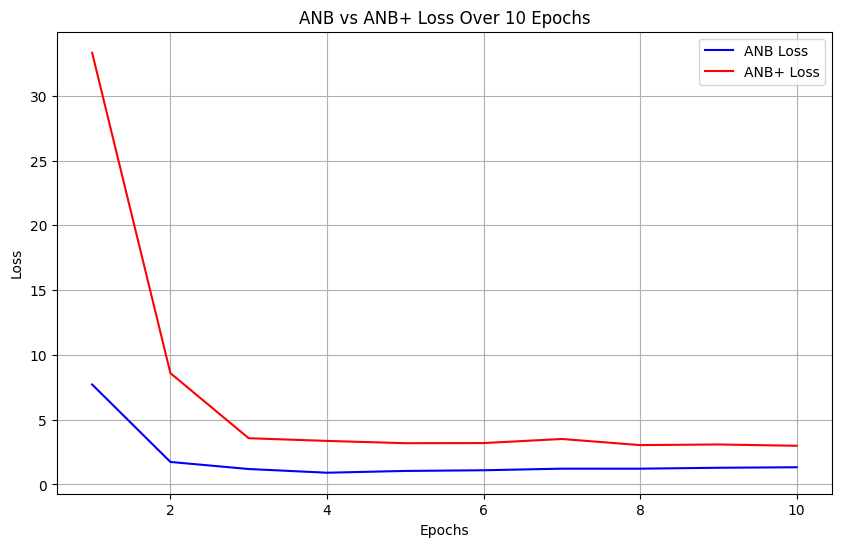

In [60]:
anb_loss = [7.71825326572765, 1.735989718726187, 1.1907941193291636, 0.9047453511844982, 1.0421886823394082,
            1.0946602189179622, 1.2177772503910642, 1.217276146917632, 1.2876203620072566, 1.3269359108173486]

anb_plus_loss = [33.32720889467181, 8.59160405216795, 3.567366361618042, 3.361121062076453, 3.1830804203495835,
                 3.194024432789196, 3.5096473115863223, 3.0364832733616685, 3.085678118647951, 2.9846522013346353]

epochs = range(1, len(anb_loss) + 1)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(epochs, anb_loss, 'b', label='ANB Loss')
plt.plot(epochs, anb_plus_loss, 'r', label='ANB+ Loss')
plt.title('ANB vs ANB+ Loss Over 10 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

## Metric Calculation

Top-k Accuracy:

- For each sample, consider the top-k predicted labels.
- Accuracy measures the proportion of samples for which at least one of the ground truth labels is among the top-k predicted labels.
- It quantifies how many samples have at least one correct prediction among the top-k predictions.
- Top-k Accuracy is calculated as the ratio of the number of samples with at least one correct prediction among the top-k predicted labels to the total number of samples.

Top-3 Recall:

- For each sample, consider the ground truth labels.
- Recall measures the proportion of correct predictions among the ground truth labels.
- It quantifies how many of the relevant (correct) labels were predicted among the top-3 predictions.
- Top-3 Recall is calculated as the ratio of the number of relevant (correct) predictions to the total number of relevant (correct) labels (up to 3).

In [70]:
def calculate_top_metrics(model, dataloader, num_classes):
    # Initialize variables to store correct predictions for top-1, top-2, and top-3
    correct_top1 = 0
    correct_top2 = 0
    correct_top3 = 0
    recall_top3 = 0


    # Total number of samples
    total = len(dataloader.dataset)

    # Set model to evaluation mode
    model.eval()
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Calculating metrics")

    # Iterate through the dataloader
    for batch_idx, batch in pbar:
        # Move inputs and labels to the appropriate device
        input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels = batch
    
        input_ids = input_ids.to(device)
        token_type_ids = token_type_ids.to(device)
        attention_mask = attention_mask.to(device)
        visual_embeds = visual_embeds.to(device)
        visual_token_type_ids = visual_token_type_ids.to(device)
        visual_attention_mask = visual_attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        with torch.no_grad():
            probabilities = model_B(input_ids, token_type_ids, attention_mask, visual_embeds, visual_token_type_ids, visual_attention_mask, labels)

       # Find the top-3 predicted probabilities and corresponding labels
        _, top3_indices = torch.topk(probabilities, 3, dim=1)

        # Check if the highest probability matches any of the labels (top-1 accuracy)
        correct_top1 += torch.sum(labels[torch.arange(len(labels)), top3_indices[:, 0]]).item()

        # Check if any of the two highest probabilities match any of the labels (top-2 accuracy)
        for i in range(len(labels)):
            if any(labels[i, top3_indices[i, :2]] == 1):
                correct_top2 += 1

        # Check if any of the top-3 probabilities match any of the labels (top-3 accuracy)
        for i in range(len(labels)):
            if any(labels[i, top3_indices[i]] == 1):
                correct_top3 += 1
            recall_top3 += torch.sum(labels[i, top3_indices[i]] == 1).item()
            
    # Calculate top-1, top-2, and top-3 accuracy
    top1_accuracy = correct_top1 / total
    top2_accuracy = correct_top2 / total
    top3_accuracy = correct_top3 / total

    # Calculate top-3 recall
    recall_top3 = recall_top3 / (3 * total)

    # Return the results as a dictionary
    results = {
        "top1_accuracy": top1_accuracy,
        "top2_accuracy": top2_accuracy,
        "top3_accuracy": top3_accuracy,
        "recall_top3": recall_top3
    }

    return results

In [80]:
anb_model = TeacherModel(visualbert_model)
checkpoint = torch.load("anb_checkpoint.pth", map_location=torch.device('cpu'))
anb_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [81]:
anb_metrics = calculate_top_metrics(anb_model, dataloader_B, NUM_EMOTIONS)
anb_metrics

Calculating metrics: 100%|█████████████████████████████████| 33/33 [03:37<00:00,  6.59s/it]


{'top1_accuracy': 0.07554479418886198,
 'top2_accuracy': 0.12493946731234867,
 'top3_accuracy': 0.17772397094430992,
 'recall_top3': 0.06230831315577078}

In [82]:
with open('anb_metrics.pkl', 'wb') as f:
    pickle.dump(anb_metrics, f)

In [83]:
anbp_model =  TeacherModel(visualbert_model)
checkpoint = torch.load("anb+_checkpoint.pth", map_location=torch.device('cpu'))
anbp_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [84]:
anbp_metrics = calculate_top_metrics(anbp_model, dataloader_B, NUM_EMOTIONS)
anbp_metrics

Calculating metrics: 100%|█████████████████████████████████| 33/33 [03:37<00:00,  6.60s/it]


{'top1_accuracy': 0.09249394673123487,
 'top2_accuracy': 0.24745762711864408,
 'top3_accuracy': 0.3917675544794189,
 'recall_top3': 0.15254237288135594}

In [86]:
with open('anbp_metrics.pkl', 'wb') as f:
    pickle.dump(anb_metrics, f)

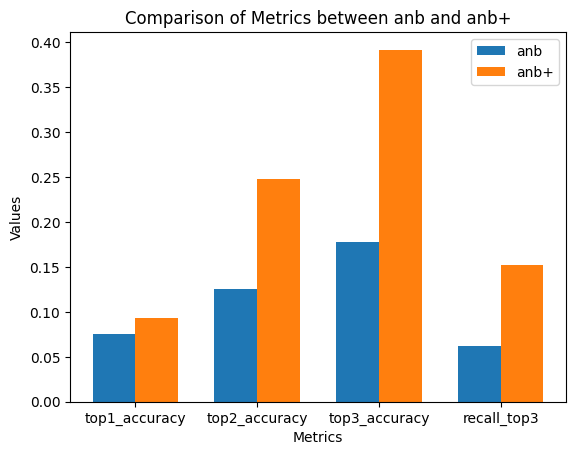

In [89]:
# Define the metric names
metric_names = list(anb_metrics.keys())

# Get the metric values for anb and anb+
anb_values = [anb_metrics[metric] for metric in metric_names]
anbp_values = [anbp_metrics[metric] for metric in metric_names]

# Set the width of the bars
bar_width = 0.35

# Set the x locations for the groups
x = np.arange(len(metric_names))

# Plot the metrics side by side
fig, ax = plt.subplots()
bars1 = ax.bar(x - bar_width/2, anb_values, bar_width, label='anb')
bars2 = ax.bar(x + bar_width/2, anbp_values, bar_width, label='anb+')

# Add labels, title, and legend
ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of Metrics between anb and anb+')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

# Show the plot
plt.show()